In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

def style_plot(fig, ax, aspect="equal", label_fontsize=20, no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect == "equal":
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels(minor=True) + ax.get_yticklabels(minor=True):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    for label in (ax.get_xticklabels(minor=False) + ax.get_yticklabels(minor=False)):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

In [201]:
class Truncated_Square:

    def __init__(self, box_side_lengths=[1, 1]):

        self.full_num_Vs = 8
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()
        self.periodic = True

    def construct_V_coords(self):

        bulk_V_coords = np.array([[1 / 2 + np.sqrt(2) / 2, 1 / 2 + np.sqrt(2)],
                                  [1 / 2 + np.sqrt(2) / 2, 1 / 2],
                                  [1 / 2 + np.sqrt(2), 1 / 2 + np.sqrt(2) / 2],
                                  [1 / 2, 1 / 2 + np.sqrt(2) / 2]]) / (1 + np.sqrt(2))
        
        boundary_V_coords = np.array((bulk_V_coords[1] + np.array([0, 1]),
                                      bulk_V_coords[0] - np.array([0, 1]),
                                      bulk_V_coords[3] + np.array([1, 0]),
                                      bulk_V_coords[2] - np.array([1, 0])))
        
        self.num_Vs = 4
        self.full_V_coords = np.vstack((bulk_V_coords, boundary_V_coords))
        self.edges = np.array(([0, 2],
                               [0, 3],
                               [1, 2],
                               [1, 3],
                               [0, 4],
                               [1, 5],
                               [2, 6],
                               [3, 7]))

In [2]:
class Delaunay_Graph:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()
        self.periodic = False
        
    def construct_V_coords(self):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        edges = []
        for v_ind in range(self.full_num_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    edges.append([v_ind, w_ind])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        self.triangulation = triangulation
            
class RGG:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()
        self.periodic = False

    def construct_V_coords(self):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        tree = scipy.spatial.cKDTree(full_V_coords)
        mean_l = 2.5 * np.abs(max_coord - min_coord) / np.sqrt(self.full_num_Vs)
        edges = np.array(list(tree.query_pairs(r=mean_l)))
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs

class Aperiodic_Monotile:

    def __init__(self, N):

        self.construct_V_coords(N)
        self.periodic = False

    def construct_V_coords(self, N):

        file = open("grid_size_150_data/V_coords.pkl", "rb")
        full_V_coords = pickle.load(file)
        file.close()
        file = open("grid_size_150_data/E_lengths_by_v_num.pkl", "rb")
        full_E_lengths_by_v_num = pickle.load(file)
        file.close()

        translate = np.array([0.1, -50.1])
        full_V_coords += translate

        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < N) & (full_V_coords[:, 1] < N))

        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask])) / N

        old_inds = np.concatenate((np.argwhere(bulk_mask).flatten(), np.argwhere(~bulk_mask).flatten()))
        new_inds = np.arange(full_V_coords.shape[0])
        remap = {i: j for i, j in zip(old_inds, new_inds)}

        old_edges = np.array(list(full_E_lengths_by_v_num.keys()))
        edges = []
        for v_ind, w_ind in old_edges:
            edges.append([remap[v_ind], remap[w_ind]])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        num_Vs = np.sum(bulk_mask)

        bulk_edges = []
        for i, j in edges:
            if i < num_Vs and j < num_Vs:
                bulk_edges.append([i, j])
        bulk_V_inds = np.unique(bulk_edges)
        disconnected_V_inds = set(np.arange(num_Vs)) - set(bulk_V_inds)
        if len(disconnected_V_inds) > 0:
            all_ok_inds = set(np.arange(full_V_coords.shape[0])) - disconnected_V_inds
            old_inds = np.concatenate((np.array(list(all_ok_inds)), np.array(list(disconnected_V_inds))))
            full_V_coords = full_V_coords[old_inds]
            new_inds = np.arange(full_V_coords.shape[0])
            remap = {i: j for i, j in zip(old_inds, new_inds)}
            new_edges = []
            for v_ind, w_ind in edges:
                new_edges.append([remap[v_ind], remap[w_ind]])
            new_edges = np.array(new_edges)
            edges = np.sort(new_edges, axis=1)
            num_Vs -= len(disconnected_V_inds)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs

In [102]:
class Patch_Graph:
    """
    g needs:
        - num_Vs            : int (number of vertices in bulk)
        - full_V_coords     : Nx2 np.array (first num_Vs are the bulk vertices)
        - edges             : Nx2 np.array (each row must be sorted ascending)
        - box_side_lengths  : list (NOT YET INCLUDED. BOX ASSUMED 1x1 FOR NOW)"""

    def __init__(self, parent_graph, autoplot=False):

        self.construct_bulk_and_boundary_attributes(parent_graph)
        print(f"num_Vs = {self.num_Vs}")
        self.construct_boundary_to_bulk_attributes()

        self.construct_NEP_data()

        if autoplot:
            self.plot_graph(parent_graph)

    def construct_NEP_data(self):

        self.interior_V_num = np.arange(self.num_Vs)
        self.wadjacency_matrices = self.construct_wadjacencies()

    def calculate_csc(self, k, l):
        return 1 / np.sin(k * l)
    
    def calculate_sec(self, k, l):
        return 1 / np.cos(k * l)
    
    def calculate_cot(self, k, l):
        return 1 / np.tan(k * l)

    def calculate_dcsc(self, k, l):
        return -l * self.calculate_csc(k, l) * self.calculate_cot(k, l)

    def calculate_dcot(self, k, l):
        return -l * self.calculate_csc(k, l)**2

    def calculate_dsec(self, k, l):
        return l * self.calculate_sec(k, l) * np.tan(k * l)
    
    def construct_wadjacencies(self):

        wadjacency_matrices = []

        bulk_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            bulk_wadjacency_matrix[v_ind, w_ind] = l_vw
            bulk_wadjacency_matrix[w_ind, v_ind] = l_vw
        bulk_wadjacency_matrix = bulk_wadjacency_matrix.tocsc()

        wadjacency_matrices.append(bulk_wadjacency_matrix)

        boundary_wadjacency_matrices = []
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                boundary_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
                l_vw = np.linalg.norm(v_coords - w_coords)
                boundary_wadjacency_matrix[v_ind, w_ind] = l_vw
                boundary_wadjacency_matrix[w_ind, v_ind] = l_vw
                boundary_wadjacency_matrix = boundary_wadjacency_matrix.tocsc()
                boundary_wadjacency_matrices.append(boundary_wadjacency_matrix)

        wadjacency_matrices += boundary_wadjacency_matrices

        return wadjacency_matrices

    def construct_L(self, k, deriv=False):

        if not deriv:
            calculate_csc = self.calculate_csc
            calculate_cot = self.calculate_cot
        else:
            calculate_csc = self.calculate_dcsc
            calculate_cot = self.calculate_dcot

        L = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))

        for wadjacency_matrix in self.wadjacency_matrices[:1]:

            matrix_csc = wadjacency_matrix.copy()
            matrix_csc.data = calculate_csc(k, matrix_csc.data)

            matrix_cot = wadjacency_matrix.copy()
            matrix_cot.data = calculate_cot(k, matrix_cot.data)
            matrix_cot = scipy.sparse.diags(matrix_cot.sum(axis=0).flat)

            L += matrix_cot - matrix_csc

        for wadjacency_matrix in self.wadjacency_matrices[1:]:
            v, w = wadjacency_matrix.nonzero()[0]
            csc = calculate_csc(k, wadjacency_matrix[v, w])
            cot = calculate_cot(k, wadjacency_matrix[v, w])
            L[v, w] -= csc
            L[w, v] -= csc
            L[v, v] += cot
            L[w, w] += cot

        L = L.tocsc()

        return L

    def construct_bulk_and_boundary_attributes(self, parent_graph):

        # Loop through v_ind, w_ind in parent_graph.edges. Construct edges and boundary edges. 
        # Indices are ordered so we know which vertices are in the graph/bulk, and which are boundary.
        # Construct also boundary vertex indices.
        edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind, w_ind in parent_graph.edges:
            if v_ind < parent_graph.num_Vs:
                edge = [v_ind, w_ind]
                if w_ind < parent_graph.num_Vs:
                    edges.append(edge)
                else:
                    w_coords = parent_graph.full_V_coords[w_ind]
                    if (not np.any(w_coords < 0)) or (w_coords[0] > 1 and w_coords[1] < 0):
                        boundary_V_inds.append(w_ind)
                        boundary_edges.append(edge)
        boundary_V_inds = np.unique(boundary_V_inds)
        V_coords = parent_graph.full_V_coords[:parent_graph.num_Vs]
        boundary_V_coords = parent_graph.full_V_coords[boundary_V_inds]
        num_Vs = V_coords.shape[0]
        num_boundary_Vs = boundary_V_coords.shape[0]
        reindex_boundary_V_coords = {i: en for en, i in enumerate(boundary_V_inds)}

        # edges is [v_ind, w_ind] where 0 <= v_ind, w_ind <= num_Vs - 1
        # boundary_edges is [v_ind, w_ind] where 0 <= v_ind <= num_Vs - 1 and 0 <= w_ind <= num_boundary_Vs - 1
        edges = np.array(edges)
        boundary_edges = np.array([[i, reindex_boundary_V_coords[j]] for i, j in boundary_edges])

        # Define bulk attributes
        self.V_coords = V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        # Define boundary attributes
        self.boundary_V_coords = boundary_V_coords
        self.boundary_edges = boundary_edges
        self.num_boundary_Vs = num_boundary_Vs

    def construct_boundary_to_bulk_attributes(self):

        # Construct boundary map
        boundary_to_bulk_map = {}
        for v_ind, v_coords in enumerate(self.boundary_V_coords):
            wrapped_v_coords = v_coords % 1
            distances = np.linalg.norm(self.V_coords - wrapped_v_coords, axis=1)
            wrapped_v_ind = distances.argmin()
            boundary_to_bulk_map[v_ind] = wrapped_v_ind

        periodic_edges = collections.defaultdict(list)
        for v_ind, w_ind in self.boundary_edges:
            bulk_w_ind = boundary_to_bulk_map[w_ind]
            periodic_edges[(v_ind, bulk_w_ind)].append(np.array((self.V_coords[v_ind], self.boundary_V_coords[w_ind])))

        # Define boundary to bulk attributes
        self.boundary_to_bulk_map = boundary_to_bulk_map
        self.periodic_edges = periodic_edges

    def construct_alpha_solve(self):

        LHS = scipy.sparse.lil_matrix((self.num_Vs + 1, self.num_Vs))

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            LHS[v_ind, w_ind] -= 1 / l_vw
            LHS[w_ind, v_ind] -= 1 / l_vw
            LHS[v_ind, v_ind] += 1 / l_vw
            LHS[w_ind, w_ind] += 1 / l_vw

        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                LHS[v_ind, w_ind] -= 1 / l_vw
                LHS[w_ind, v_ind] -= 1 / l_vw
                LHS[v_ind, v_ind] += 1 / l_vw
                LHS[w_ind, w_ind] += 1 / l_vw

        RHS = scipy.sparse.lil_matrix((self.num_Vs + 1, 2))
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                v_x_coords = self.v_coords_to_x_coords(v_coords)
                w_x_coords = self.v_coords_to_x_coords(w_coords) 
                r_xy = w_x_coords - v_x_coords
                RHS[v_ind] += r_xy / l_vw
                RHS[w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_Vs)
        LHS = LHS.tocsc()
        RHS = RHS.tocsc()

        return LHS, RHS

    # def construct_boundary_edges(self):

        # # Construct boundary map
        # boundary_to_bulk_map = {}
        # for v_ind, v_coords in enumerate(boundary_V_coords):
        #     wrapped_v_coords = v_coords % 1
        #     r_xy = v_coords - wrapped_v_coords
        #     distances = np.linalg.norm(V_coords - wrapped_v_coords, axis=1)
        #     wrapped_v_ind = distances.argmin()
        #     boundary_to_bulk_map[v_ind] = [wrapped_v_ind, r_xy]

        # # For remapping bulk to boundary to **update** exact l_vw's
        # periodic_edges = {}
        # for v_ind, w_ind in boundary_edges:
        #     w_ind, w_translation = boundary_to_bulk_map[w_ind]
        #     periodic_edges[(v_ind, w_ind)] = np.array((V_coords[v_ind], V_coords[w_ind] + w_translation))

    def plot_graph(self, parent_graph):

        # Plot graph
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_subplot(111)
        # ax.set_xlim(-0.1, 1.1)
        # ax.set_ylim(-0.1, 1.1)

        ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='orange', facecolor='none'))

        # Plot the lines between neighbors
        for i, j in self.edges:
            point1 = self.V_coords[i]
            point2 = self.V_coords[j]
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
        for i, j in self.periodic_edges:
            for point1, point2 in self.periodic_edges[i, j]:
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'green', linewidth=1)
        
        # ax.triplot(parent_graph.full_V_coords[:, 0], parent_graph.full_V_coords[:, 1], parent_graph.triangulation.simplices)

        # ax.scatter(self.V_coords[:, 0], self.V_coords[:, 1], color='blue', s=30, zorder=10)
        ax.scatter(self.boundary_V_coords[:, 0], self.boundary_V_coords[:, 1], color='red', s=30, zorder=10)

        # for en, v in enumerate(self.V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

        # for en, v in enumerate(self.boundary_V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords

In [243]:
class Patch:

    """graph needs:
        - full_num_Vs: total number of vertices without rejection
        - num_Vs: number of vertices inside square
        - full_V_coords: full_num_Vs * 2 np.array of all vertex coords
        - edges: (v, w) where v < w
    """

    """Parent class of more specific graph classes (spiderweb, delaunay triangulations etc.)
    These child classes need the attributes:
        - num_Vs
        - V_coords
        - E_lengths_by_v_num
        - interior_V_num
        - wadjacency_matrix
    """
    
    def __init__(self, graph):

        self.graph = graph

        self.bulk_edges, self.periodic_edges = self.construct_bulk_and_boundary_edges()
        self.num_Vs = self.graph.num_Vs
        self.V_coords = self.graph.full_V_coords[:self.num_Vs]
        self.interior_V_num = np.arange(self.num_Vs)

    def construct_correction_problem(self):

        LHS = scipy.sparse.lil_matrix((self.num_Vs + 1, self.num_Vs)) 
        LHS[-1] = np.ones(self.num_Vs)
        
        RHS = scipy.sparse.lil_matrix((self.num_Vs + 1, 2))

        for v_ind, w_ind in self.bulk_edges:
            l_vw = np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])
            num_edges = self.bulk_edges[v_ind, w_ind][0]
            weight = num_edges * 1 / l_vw

            LHS[v_ind, v_ind] += weight
            LHS[w_ind, w_ind] += weight
            LHS[v_ind, w_ind] -= weight
            LHS[w_ind, v_ind] -= weight 

        for v_ind, w_ind in self.periodic_edges:
            v_coords, w_coords = self.periodic_edges[v_ind, w_ind][1]
            l_vw = np.linalg.norm(w_coords - v_coords)
            weight = num_edges * 1 / l_vw

            LHS[v_ind, v_ind] += weight
            LHS[w_ind, w_ind] += weight
            LHS[v_ind, w_ind] -= weight
            LHS[w_ind, v_ind] -= weight 

            r_xy = w_coords - (w_coords % np.array([1, 1]))

            RHS[v_ind] += weight * r_xy 
            RHS[w_ind] -= weight * r_xy 

        return LHS, RHS

    def construct_bulk_and_boundary_edges(self):
        """Construct bulk and boundary edges from self.graph.edges"""
        bulk_edges = collections.defaultdict(list)
        periodic_edges = collections.defaultdict(list)
        for v_ind, w_ind in self.graph.edges:
            if (v_ind < self.graph.num_Vs) and (w_ind < self.graph.num_Vs):
                v_coords = self.graph.full_V_coords[v_ind]
                w_coords = self.graph.full_V_coords[w_ind]
                bulk_edges[v_ind, w_ind].append(np.array((v_coords, w_coords)))
            elif (v_ind < self.graph.num_Vs) and not (w_ind < self.graph.num_Vs):
                v_coords = self.graph.full_V_coords[v_ind]
                w_coords = self.graph.full_V_coords[w_ind]
                wrapped_w_coords = w_coords % np.array([1, 1])
                r_xy = w_coords - wrapped_w_coords
                remapped_w_ind = np.argmin(np.linalg.norm(self.graph.full_V_coords[:self.graph.num_Vs] - wrapped_w_coords, axis=1))
                remapped_w_coords = self.graph.full_V_coords[remapped_w_ind] + r_xy
                periodic_edges[v_ind, remapped_w_ind].append(np.array((v_coords, remapped_w_coords)))
        bulk_edges = dict(bulk_edges)
        periodic_edges = dict(periodic_edges)

        bulk_edges = {key: [len(value), value[0]] for key, value in bulk_edges.items()}
        periodic_edges = {key: [len(value), value[0]] for key, value in periodic_edges.items()}

        periodic_edges = self.tidy_edges(periodic_edges)
        periodic_edges = self.prune_edges(periodic_edges)

        return bulk_edges, periodic_edges

    def tidy_edges(self, edges_to_be_tidied):
        """This merges edges (v, w) and (w, v).
        If (v, w) is already counted, then any instances of (w, v) are added.
        Otherwise, the (w, v)s are just added as their own set.
        In the end, all edges (v, w) are so that v < w and the w is outside the box."""
        edges = {}
        for v_ind, w_ind in edges_to_be_tidied:
            if v_ind < w_ind:
                edges[v_ind, w_ind] = edges_to_be_tidied[v_ind, w_ind].copy()
        for v_ind, w_ind in edges_to_be_tidied:
            if w_ind < v_ind:
                if (w_ind, v_ind) in edges_to_be_tidied:
                    edges[w_ind, v_ind][0] += edges_to_be_tidied[v_ind, w_ind][0]
                else:
                    num_edges = edges_to_be_tidied[v_ind, w_ind][0]
                    v_coords, w_coords = edges_to_be_tidied[v_ind, w_ind][1]
                    wrapped_w_coords = w_coords % np.array([1, 1])
                    r_xy = w_coords - wrapped_w_coords
                    edges[w_ind, v_ind] = [num_edges, np.array([wrapped_w_coords, v_coords - r_xy])]

        return edges
 
    def prune_edges(self, edges_to_be_pruned):
        """There are twice as many periodic edges on average. 
        For periodic graph, prune doubly counted edges.
        For random patch, prune edges uniformly randomly."""
        edges = {}

        if self.graph.periodic:
            for v_ind, w_ind in edges_to_be_pruned:
                edges[v_ind, w_ind] = edges_to_be_pruned[v_ind, w_ind].copy()
                edges[v_ind, w_ind][0] = 1
        else:
            for v_ind, w_ind in edges_to_be_pruned:
                num_edges = edges_to_be_pruned[v_ind, w_ind][0]
                random_sampling_num = np.random.choice(num_edges + 1)
                if random_sampling_num != 0:
                    edges[v_ind, w_ind] = edges_to_be_pruned[v_ind, w_ind].copy()
                    edges[v_ind, w_ind][0] = random_sampling_num
        
        return edges

In [290]:
# np.random.seed(0)
dg = Delaunay_Graph(30000)
g = Patch(dg)

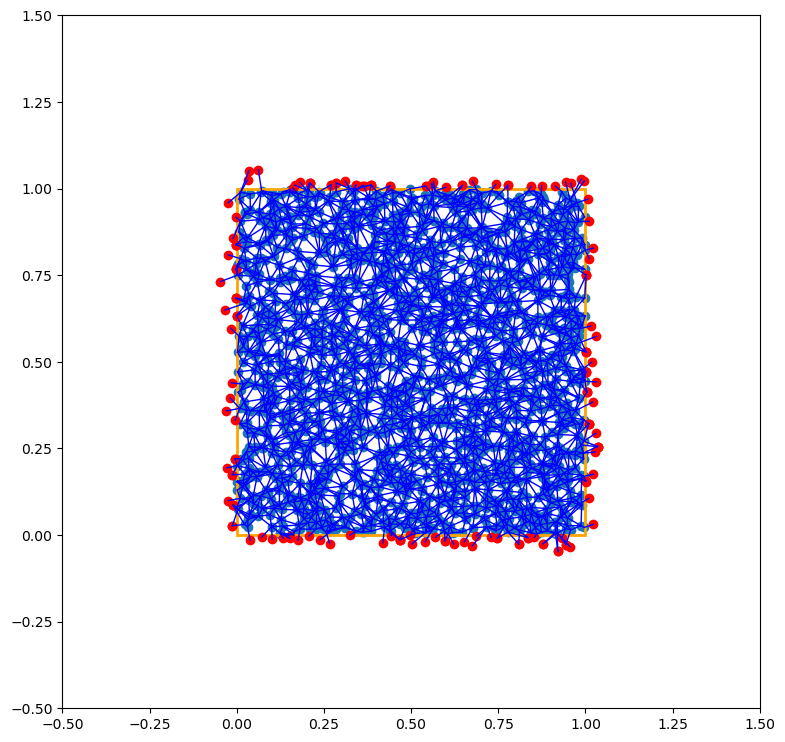

In [264]:
fig = plt.figure(figsize=(9, 9))
ax=fig.add_subplot(111)
ax.scatter(dg.full_V_coords[:dg.num_Vs, 0], dg.full_V_coords[:dg.num_Vs, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
# for en, v in enumerate(dg.full_V_coords[:dg.num_Vs]):
#     ax.annotate(str(en), v, fontsize=15)
ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='orange', facecolor='none'))

for i, j in g.bulk_edges:
    point1 = dg.full_V_coords[i]
    point2 = dg.full_V_coords[j]
    ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
for i, j in g.periodic_edges:
    point1 = g.periodic_edges[i, j][1][0]
    point2 = g.periodic_edges[i, j][1][1]
    ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
    ax.scatter(point2[0], point2[1], c='r')#, s=100)
    # ax.annotate(str(i), point1, fontsize=15)
    # ax.annotate(str(j), point2, fontsize=15)
# for i, j in dg.edges:
#     point1 = dg.full_V_coords[i]
#     point2 = dg.full_V_coords[j]
#     ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1, alpha=0.2)
#     ax.scatter(point2[0], point2[1], c='r', s=20, alpha=0.2)
#     ax.annotate(str(i), point1, fontsize=15, alpha=0.2)
#     ax.annotate(str(j), point2, fontsize=15, alpha=0.2)

In [291]:
g.num_Vs

15250

In [285]:
# dg = Truncated_Square()
# g = Patch(dg)

In [292]:
LHS, RHS = g.construct_correction_problem()

In [293]:
xi = sparseqr.solve(LHS, RHS)
xi = xi.toarray()

In [294]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.bulk_edges:

    v_coords, w_coords = g.bulk_edges[v_ind, w_ind][1]
    a = xi[w_ind] - xi[v_ind]
    l_vw = np.linalg.norm(w_coords - v_coords)

    Q += np.tensordot(a, a, axes=0) / l_vw
    T += l_vw

for v_ind, w_ind in g.periodic_edges:
    
    num_edges = g.periodic_edges[v_ind, w_ind][0]
    v_coords, w_coords = g.periodic_edges[v_ind, w_ind][1]

    l_vw = np.linalg.norm(w_coords - v_coords)

    r_xy = w_coords - (w_coords % np.array([1, 1]))
    a = r_xy + xi[w_ind] - xi[v_ind]

    Q += np.tensordot(a, a, axes=0) / l_vw
    T += l_vw

Q /= T

In [296]:
np.trace(Q) / 0.9201787597623325

0.9966832547662484

In [ ]:
0.9201787597623325